# Etude théorique des profils

On importe d'abord les modules nécessaires

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve

import scienceplots

plt.rcParams.update({
    'font.size': 14,       # Taille de police générale
    'axes.titlesize': 19,  # Taille de la police du titre des axes
    'axes.labelsize': 16,  # Taille de la police des étiquettes des axes
    'xtick.labelsize': 13, # Taille de la police des étiquettes des graduations en x
    'ytick.labelsize': 13, # Taille de la police des étiquettes des graduations en y
    'legend.fontsize': 13, # Taille de la police de la légende
    'figure.titlesize': 20 # Taille de la police du titre de la figure
})

Les hauteurs sont celles de l'expérience.

In [4]:
h = 7e-3
a0 = 4e-3

### Fonctions pour le profil exponentiel

On définit les fonctions nécessaires pour l'étude du profil exponentiel

In [5]:
def a_exp(a0, lamb, z):
    return a0*np.exp(lamb*z)

Obtention de $\lambda$ par conservation de l'aire

In [6]:
def find_lamb_exp(h, h_tronq, initial_guess=1):
    """
    Trouve la valeur de lambda qui satisfait l'équation donnée pour des valeurs de h et n.

    Parameters:
    h (float): Valeur de h.
    n (float): Valeur de n.
    initial_guess (float): Estimation initiale pour lambda. Par défaut à 1.0.

    Returns:
    float: Valeur de lambda qui satisfait l'équation.
    """
    
    # Définir la fonction qui représente l'équation
    def equation(lambda_):
        return h - (1/(lambda_)) * (np.exp(lambda_ * h_tronq) - 1)

    # Résoudre l'équation
    lambda_solution, = fsolve(equation, initial_guess)

    return lambda_solution

In [7]:
def temps_exp(lam, h_tronq):
    return -h_tronq/lam + (1/(lam**2))*(np.exp(lam*h_tronq)-1)

### Fonctions pour le profil cônique

Même chose pour les profils coniques

In [8]:
def a_cone(a0, beta, z):
    return a0*(1+beta*z)

In [9]:
def find_beta_cone(h, h_tronq):
    return 2/(h_tronq**2)*(h-h_tronq)

In [10]:
def temps_cone(beta, h_tronq):
    u = 1 + beta*h_tronq
    Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
    return Dt

### Fonctions pour les profils en loi de puissance

On conviendra que $b$ est la puissance et $\mu$ le coefficient devant la puissance. Pour l'instant, on se restreint aux profils simples $a(z) = a_0(1+\mu z^b)$

Pour trouver les valeurs limites de $h_{tronq}$ et de $\mu$, on doit résoudre un système numériquement.

In [11]:
def equations(vars, h, b):
    h_tronq, mu = vars
    eq1 = mu - (b + 1) * (h - h_tronq) / (h_tronq**(b + 1))
    eq2 = 1 + mu * h_tronq**b
    return [eq1, eq2]

def find_limits(h, b):
    # Initial guess for h_tronq and mu (should be positive for h_tronq)
    h_tronq_guess = h+0.00001
    mu_guess = -1e3
    initial_guess = [h_tronq_guess, mu_guess]

    # Solve the system
    solution = fsolve(equations, initial_guess, args=(h, b))

    # Check if the solution for h_tronq is positive
    if solution[0] > 0:
        return solution
    else:
        return None

Testons pour une loi de puissance quadratique

In [12]:
print(r"La valeur limite de $h_{tronq}$ pour $b=2$ est ", find_limits(h, 2)[0])
print(r"La valeur limite de $\mu$ pour $b=2$ est ", find_limits(h, 2)[1])

La valeur limite de $h_{tronq}$ pour $b=2$ est  0.010499999999993112
La valeur limite de $\mu$ pour $b=2$ est  -9070.294784582231


Maintenant, on peut donc trouver les autres valeurs de $\mu$ selon la hauteur de crop

In [13]:
def find_mu(h, h_tronq, b):
    mu = (b+1)*(h-h_tronq)/(h_tronq**(b+1))
    return mu

In [14]:
def a_puiss(mu, alpha, a0, z):
    return a0*(1+mu*z**alpha)

### Trouver la hauteur maximale accessible par les lois de puissance.

In [15]:
from scipy.optimize import bisect

In [17]:
def find_h_max(h, b, a0):
    h_t = np.concatenate((np.linspace(0.0001, h-0.000001, 100), np.linspace(h+0.000001, 2*h, 100)))
    mu_t = f_mu(h, h_t, b)
    
    larg = []
    
    for i in range(len(h_t)):
        larg.append(a_puiss(mu_t[i], b, a0, h_t[i]))
        
    root = bisect(lambda z: a_puiss(f_mu(h, z, b), b, a0, z), 2e-3, 10*h)
    
    """
    Pour vérifier qu'on ne se trompe pas !
    """
    
    """
    z = np.linspace(0, root, 100)
    plt.plot(z, a_puiss(f_mu(h, root, b), b, a0, z), color='red')
    plt.plot([0, root], [0, 0], color='blue', linestyle=':')
    """
    
    #plt.scatter([root], [0], color='blue')
    #plt.plot(h_t, a_puiss(f_mu(h, h_t, b), b, a0, h_t), color='red')
    
    return root


In [18]:
f_h_max_vect = np.vectorize(find_h_max)

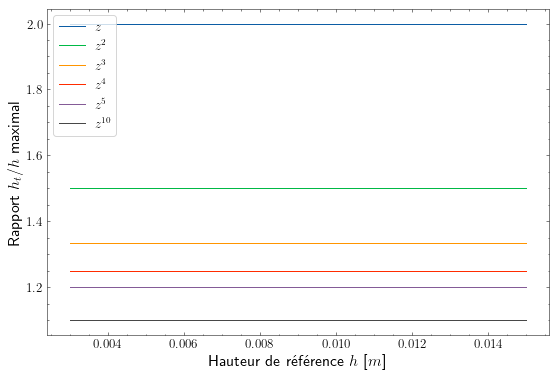

In [19]:
with plt.style.context('science'):
    h_range = np.linspace(3e-3, 15e-3)

    plt.figure(figsize=[9,6])

    plt.plot(h_range, 2*h_range/h_range, label=r"$z$")
    plt.plot(h_range, f_h_max_vect(h_range, 2, a0)/h_range, label=r"$z^2$")
    plt.plot(h_range, f_h_max_vect(h_range, 3, a0)/h_range, label=r"$z^3$")
    plt.plot(h_range, f_h_max_vect(h_range, 4, a0)/h_range, label=r"$z^4$")
    plt.plot(h_range, f_h_max_vect(h_range, 5, a0)/h_range, label=r"$z^5$")

    plt.plot(h_range, f_h_max_vect(h_range, 10, a0)/h_range, label=r"$z^{10}$")

    plt.xlabel(r'Hauteur de référence $h$ [$m$]')
    plt.ylabel(r'Rapport $h_t/h$ maximal')

    plt.legend(loc='upper left', frameon=True)

En fait, on peut l'obtenir théoriquement, le rapport maximal atteint par un profil factorisé de type $z^b$ est donné par :
$$h_t/h = (b+1)/b$$

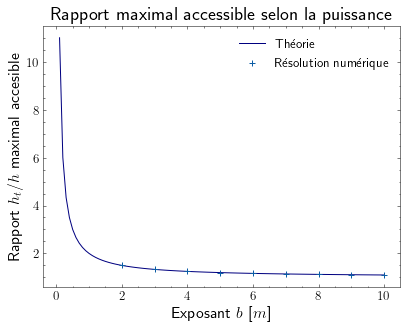

In [20]:
with plt.style.context('science'):
    
    plt.figure(figsize=[6.4,4.8])
    
    b = np.linspace(0.1, 10, 100)
    h = 7e-3

    b_e = []
    r_e = []

    for i in range(2,11):
        b_e.append(i)
        r_e.append(find_h_max(h, i, a0)/h)

    plt.plot(b, (b+1)/b, label='Théorie', color='navy')
    #plt.plot(-b, (-b-1)/(-b), color='navy')
    plt.plot(b_e, r_e, '+', label='Résolution numérique')
    
    plt.xlabel(r'Exposant $b$ [$m$]')
    plt.ylabel(r'Rapport $h_t/h$ maximal accesible')
    plt.title('Rapport maximal accessible selon la puissance')

    plt.legend()
    
    #plt.savefig('RapportMax_access_puiss.pdf')

**Conclusion partielle** : Si on souhaite un rapport $h_t/h>1$, il faut prendre une loi de puissance avec $b \geq 1$. Le choix de la puissance est donné par la courbe ci-dessous.

Donc à rapport $h_t/h>1$ fixé, la puissance qui donne le meilleur temps de congélation est $b$ donnée par : 
    $$b = \dfrac{1}{h_t/h-1}$$

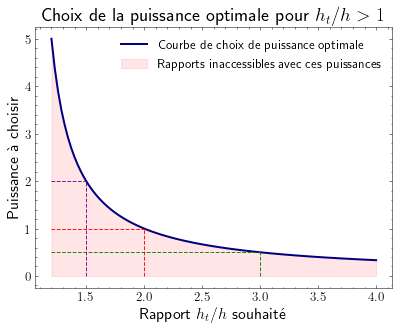

In [21]:
plt.switch_backend('pdf')

with plt.style.context('science'):
    
    plt.figure(figsize=[6.4,4.8])
    
    rap = np.linspace(1.2, 4, 100)
    plt.plot(rap, 1/(rap-1), label='Courbe de choix de puissance optimale', color='navy', linewidth=2)
    
    plt.xlabel(r'Rapport $h_t/h$ souhaité')
    plt.ylabel(r'Puissance à choisir')
    
    plt.plot([2, 2], [0, 1], linestyle ='--', color='red', alpha=0.9)
    plt.plot([np.min(rap), 2], [1, 1], linestyle ='--', color='red', alpha=0.9)
    
    plt.plot([np.min(rap), 3], [1/2, 1/2], linestyle ='--', color='green', alpha=0.9)
    plt.plot([3,3], [0, 1/2], linestyle ='--', color='green', alpha=0.9)
    
    plt.plot([np.min(rap), 1.5], [1/(1.5-1), 1/(1.5-1)], linestyle ='--', color='purple', alpha=0.9)
    plt.plot([1.5,1.5], [0, 1/(1.5-1)], linestyle ='--', color='purple', alpha=0.9)
    
    plt.fill_between(rap, 1/(rap-1), 0, color='red', alpha=0.1, label="Rapports inaccessibles avec ces puissances")
    #plt.fill_between(rap, 1/(rap-1), np.max(1/(rap-1)), color='green', alpha=0.1, label="Zone autorisée")
    
    plt.legend()
    
    plt.title(r'Choix de la puissance optimale pour $h_t/h>1$')
    
    #plt.savefig("ChoixPuiss_selon_rapport.pdf")

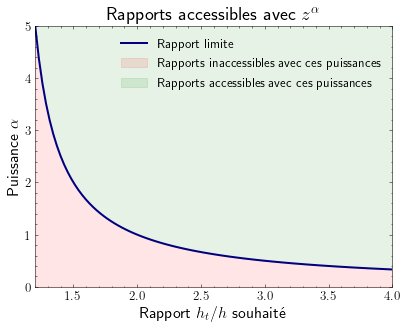

In [22]:
with plt.style.context('science'):
    
    plt.figure(figsize=[6.4,4.8])
    
    rap = np.linspace(1.2, 4, 100)
    plt.plot(rap, 1/(rap-1), label='Rapport limite', color='navy', linewidth=2)
    
    plt.xlabel(r'Rapport $h_t/h$ souhaité')
    plt.ylabel(r'Puissance $\alpha$')
    
    #plt.plot([2, 2], [0, 1], linestyle ='--', color='red', alpha=0.9)
    #plt.plot([np.min(rap), 2], [1, 1], linestyle ='--', color='red', alpha=0.9)
    
    #plt.plot([np.min(rap), 3], [1/2, 1/2], linestyle ='--', color='green', alpha=0.9)
    #plt.plot([3,3], [0, 1/2], linestyle ='--', color='green', alpha=0.9)
    
    #plt.plot([np.min(rap), 1.5], [1/(1.5-1), 1/(1.5-1)], linestyle ='--', color='purple', alpha=0.9)
    #plt.plot([1.5,1.5], [0, 1/(1.5-1)], linestyle ='--', color='purple', alpha=0.9)
    
    plt.fill_between(rap, 1/(rap-1), 0, color='red', alpha=0.1, label="Rapports inaccessibles avec ces puissances")
    plt.fill_between(rap, 1/(rap-1), 5, color='green', alpha=0.1, label="Rapports accessibles avec ces puissances")
    #plt.fill_between(rap, 1/(rap-1), np.max(1/(rap-1)), color='green', alpha=0.1, label="Zone autorisée")
    
    plt.legend()
    plt.xlim(1.2,4)
    plt.ylim(0, 5)
    
    plt.title(r'Rapports accessibles avec $z^\alpha$')
    
    #plt.savefig("Theta_Beamer.pdf")

## Fonctions nécessaires au calcul des temps de congélation

In [23]:
def find_h_max(h, b, a0):
    h_t = np.concatenate((np.linspace(1e-8, h-0.000001, 100), np.linspace(h+0.000001, 2*h, 100)))
    mu_t = f_mu(h, h_t, b)
    
    larg = []
    
    for i in range(len(h_t)):
        larg.append(a_puiss(mu_t[i], b, a0, h_t[i]))
        
    root = bisect(lambda z: a_puiss(f_mu(h, z, b), b, a0, z), 1e-8, 10*h)
    
    """
    Pour vérifier qu'on ne se trompe pas !
    """
    
    """
    z = np.linspace(0, root, 100)
    plt.plot(z, a_puiss(f_mu(h, root, b), b, a0, z), color='red')
    plt.plot([0, root], [0, 0], color='blue', linestyle=':')
    """
    
    #plt.scatter([root], [0], color='blue')
    #plt.plot(h_t, a_puiss(f_mu(h, h_t, b), b, a0, h_t), color='red')
    
    return root

f_h_max_vect = np.vectorize(find_h_max)

In [24]:
def integrand_inner(x, mu, b):
    return 1 / (1 + mu * x**b)

def integrand_outer(z, mu, b):
    inner_integral, _ = quad(integrand_inner, 0, z, args=(mu, b))
    return (1 + mu * z**b) * inner_integral

def temps_congel(mu, b, h):
    result, _ = quad(integrand_outer, 0, h, args=(mu, b))
    return result

In [52]:
#@jit(nopython=True)
def temps_congel_level(b, h_t, a0=4e-3, h=7e-3):
    # Vérification de la valeur de h avec la valeur limite.
    h_lim = find_h_max(h, b, a0)
    #eps = 1e-6
    
    """Debogage"""
    
    #print("Valeur de h_lim", h_lim)
    #print("Valeur de b", b)
    #print("Valeur de h_t", h_t)
    
    if h_t >= 0 and h_t <= h_lim:
        
        mu = find_mu(h, h_t, b)
    
        result, _ = quad(integrand_outer, 0, h_t, args=(mu, b))
        return result
    else:
        return np.nan

#@jit(nopython=True)
tc_level_vect = np.vectorize(temps_congel_level)

In [29]:
def temps_para(mu, h_tronq):
    x = h_tronq
    deno = 6*np.sqrt(mu)
    num = -mu*x**2 - 2*np.log(1+mu*x**2) + 2*np.sqrt(mu)*x*(mu*x**2+3)*np.arctan(np.sqrt(mu) * x)
    return num/deno * 1/(np.sqrt(mu))

### Comparaison des profils.

Maintenant, on peut générer une plage de valeurs pour $h_{tronq}$ et regarder quel profil permet un temps de congélation optimal.

In [35]:
h_tronq = np.concatenate((np.linspace(0.003, h-0.0005, 10), np.linspace(h+0.0005, 2*h-1e-8, 10)))

h_lim2, h_lim3, h_lim4 = find_h_max(h, 2, a0), find_h_max(h, 3, a0), find_h_max(h, 4, a0)

mask2 = np.array([value <= h_lim2 for value in h_tronq])
mask3 = np.array([value <= h_lim3 for value in h_tronq])
mask4 = np.array([value <= h_lim4 for value in h_tronq])

In [36]:
lam, beta, mu2, mu3, mu4 = [], [], [], [], []

for i in range(len(h_tronq)):
    lam.append(find_lamb_exp(h, h_tronq[i]))
    beta.append(find_beta_cone(h, h_tronq[i]))
    
    if h_tronq[i] <= np.max(h_tronq[mask2]):
        mu2.append(find_mu(h, h_tronq[i], 2))
        if h_tronq[i] <= np.max(h_tronq[mask3]):
            mu3.append(find_mu(h, h_tronq[i], 3))
            if h_tronq[i] <= np.max(h_tronq[mask4]):
                mu4.append(find_mu(h, h_tronq[i], 4))

In [37]:
colors = [
    'b',        # Blue
    'g',        # Green
    'r',        # Red
    'c',        # Cyan
    'm',        # Magenta
    'y',        # Yellow
    'k',        # Black
    '#ff7f0e',  # Orange
    '#9467bd'   # Purple
]

Visualisation

Text(0.5, 1.0, 'Différents profils')

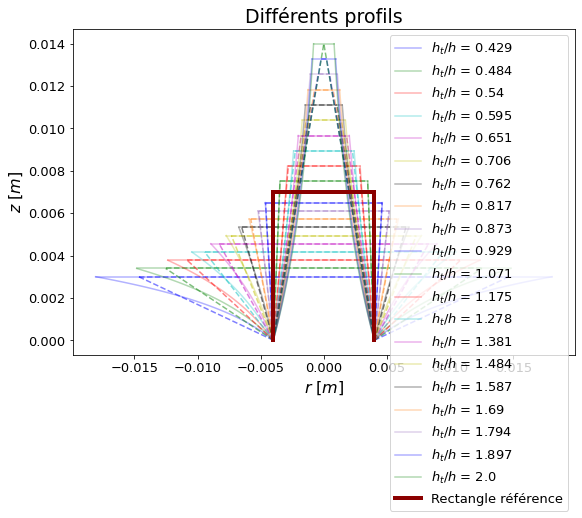

In [38]:
plt.figure(figsize=[9,6])

for i in range(len(h_tronq)):
    
    c = colors[i%9]
    z = np.linspace(0, h_tronq[i], 100)
    
    """Tracé des exponentielles"""
    
    plt.plot(a_exp(a0, lam[i], z),z, color=c, label=r'$h_t/h$ = {}'.format(round(h_tronq[i]/h,3)), alpha=0.3)
    plt.plot(-a_exp(a0, lam[i],z),z, color=c, alpha=0.3)
    plt.plot([-a_exp(a0, lam[i], h_tronq[i]), a_exp(a0, lam[i], h_tronq[i])], [h_tronq[i],h_tronq[i]], color=c, alpha=0.3)
    
    """Tracé des cônes"""
    
    plt.plot(a_cone(a0, beta[i], z), z, color=c, linestyle='dashed', alpha=0.5)
    plt.plot(-a_cone(a0, beta[i], z), z, color=c, linestyle='dashed', alpha=0.5)
    plt.plot([-a_cone(a0, beta[i], h_tronq[i]), a_cone(a0, beta[i], h_tronq[i])], [h_tronq[i],h_tronq[i]], color=c, linestyle='dashed', alpha=0.5)
    
    """Tracé des paraboles"""
    
    """
    if h_tronq[i] <= h_lim2 :
        
        plt.plot(a_puiss(mu2[i], 2, a0, z), z, c, linestyle='dashed')
        plt.plot(-a_puiss(mu2[i], 2, a0, z), z, c, linestyle='dashed')
    
        a_t = a_puiss(mu2[i],2,a0, h_tronq[i])
        plt.plot([a_t, -a_t], [h_tronq[i], h_tronq[i]], c, linestyle='dashed')
    """
    

    """Tracé des z^3"""
    
    """
    if h_tronq[i] <= h_lim3 :
        
        plt.plot(a_puiss(mu3[i], 3, a0, z), z, c, linestyle='-.')
        plt.plot(-a_puiss(mu3[i], 3, a0, z), z, c, linestyle='-.')
    
        a_t = a_puiss(mu3[i],3,a0, h_tronq[i])
        plt.plot([a_t, -a_t], [h_tronq[i], h_tronq[i]], c, linestyle='-.')
    """
    
    """Tracé des z^4"""
    
    """
    if h_tronq[i] <= h_lim4 :
        
        plt.plot(a_puiss(mu4[i], 4, a0, z), z, c, linestyle=':')
        plt.plot(-a_puiss(mu4[i], 4, a0, z), z, c, linestyle=':')
    
        a_t = a_puiss(mu4[i],4,a0, h_tronq[i])
        plt.plot([a_t, -a_t], [h_tronq[i], h_tronq[i]], c, linestyle=':')
    """

"""Rectangle"""
plt.plot([a0, a0], [0, h], 'darkred', linewidth=4, label='Rectangle référence')
plt.plot([-a0, -a0], [0, h], 'darkred', linewidth=4)
plt.plot([-a0, a0], [h, h], 'darkred', linewidth=4)

plt.legend()
plt.xlabel(r'$r$ [$m$]')
plt.ylabel(r'$z$ [$m$]')
plt.title("Différents profils")

### Calcul des temps de congélation en vectoriel

In [42]:
t_exp = np.array([28, 37, 43, 48 , 55 , 59, 70, 95, 60+51, 120+13, 120+32])
#np.array([28, 37, 43, 48 , 55 , 59, 74, 63+35, 120+1, 120+19, 120+35])
t_cone = np.array([24, 30, 40, 44, 49, 59, 67, 87, 95, 120+4, 144])
#np.array([24, 30, 40, 44, 49, 59, 70, 80, 60+35, 120+8, 144])
h_tronq_e = np.array([2.8, 3.64, 4.48, 5.32, 6.16, 7, 8.4, 9.8, 11.2, 12.6, 14])*1e-3
h = 7e-3
a0 = 4e-3

h_lim2, h_lim3, h_lim4 = find_h_max(h, 2, a0), find_h_max(h, 3, a0), find_h_max(h, 4, a0)
h_lim_05 = find_h_max(h, 0.5, a0)

h_error = 0.0004
t_error = 3.5

h_tronq = np.concatenate((np.linspace(2.8, 6.99, 100), np.linspace(7.01, 13.99, 100)))*1e-3

mask2 = np.array([value <= h_lim2 for value in h_tronq])
mask3 = np.array([value <= h_lim3 for value in h_tronq])
mask4 = np.array([value <= h_lim4 for value in h_tronq])
mask_05 = np.array([value <= h_lim_05 for value in h_tronq])

In [43]:
mu_05 = []
Dt_05 = []

for i in range(len(h_tronq)):
    if h_tronq[i] <= h_lim_05:
        mu_05.append(find_mu(h, h_tronq[i], 0.5))
        Dt_05.append(temps_congel(mu_05[i], 0.5, h_tronq[i]))
        
Dt_05 = np.array(Dt_05)


lam, beta,mu2, mu3, mu4 = [], [], [], [], []

for i in range(len(h_tronq)):
    lam.append(find_lamb_exp(h, h_tronq[i]))
    beta.append(find_beta_cone(h, h_tronq[i]))
    
    if h_tronq[i] <= np.max(h_tronq[mask2]):
        mu2.append(find_mu(h, h_tronq[i], 2))
        if h_tronq[i] <= np.max(h_tronq[mask3]):
            mu3.append(find_mu(h, h_tronq[i], 3))
            if h_tronq[i] <= np.max(h_tronq[mask4]):
                mu4.append(find_mu(h, h_tronq[i], 4))
                

lam = np.array(lam)
beta = np.array(beta)
                
Dt_2, Dt_3, Dt_4 = [], [], []

for i in range(len(h_tronq)):
    
    if h_tronq[i] <= np.max(h_tronq[mask2]):
        Dt_2.append(temps_congel(mu2[i], 2, h_tronq[i]))
        if h_tronq[i] <= np.max(h_tronq[mask3]):
            Dt_3.append(temps_congel(mu3[i], 3, h_tronq[i]))
            if h_tronq[i] <= np.max(h_tronq[mask4]):
                Dt_4.append(temps_congel(mu4[i], 4, h_tronq[i]))
                
Dt_2_theo = temps_para(np.array(mu2), h_tronq[mask2])
Dt_2 = np.array(Dt_2)
Dt_3 = np.array(Dt_3)
Dt_4 = np.array(Dt_4)


<ipython-input-29-68ffa7921cf6>:3: RuntimeWarning: invalid value encountered in sqrt
  deno = 6*np.sqrt(mu)
<ipython-input-29-68ffa7921cf6>:4: RuntimeWarning: invalid value encountered in sqrt
  num = -mu*x**2 - 2*np.log(1+mu*x**2) + 2*np.sqrt(mu)*x*(mu*x**2+3)*np.arctan(np.sqrt(mu) * x)
<ipython-input-29-68ffa7921cf6>:5: RuntimeWarning: invalid value encountered in sqrt
  return num/deno * 1/(np.sqrt(mu))


In [44]:
t_exp_th = temps_exp(np.array(lam), h_tronq)/D
t_cone_th = temps_cone(np.array(beta), h_tronq)/D

t_rect_e = 59
t_rect_th = h**2/(2*D)

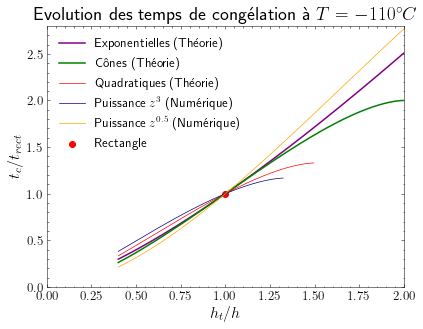

In [45]:
xmin = 0
xmax = 2
ymin = 0
ymax = 2.8

with plt.style.context('science'):
    plt.figure(figsize=[6.4,4.8])
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.plot(h_tronq/h, t_exp_th/t_rect_th, label="Exponentielles (Théorie)", color='purple', linewidth=1.5)
    plt.plot(h_tronq/h, t_cone_th/t_rect_th, label="Cônes (Théorie)", color="green", linewidth=1.5)
    plt.plot(h_tronq[mask2]/h, Dt_2/(h**2/2), label="Quadratiques (Théorie)", color='red', linewidth=0.7)
    plt.plot(h_tronq[mask3]/h, Dt_3/(h**2/2), label=r'Puissance $z^3$ (Numérique)', color='navy', linewidth=0.7)
    #plt.plot(h_tronq[mask4]/h, Dt_4/(h**2/2), label=r'Puissance $z^4$ (Numérique)', color='cyan')
    
    
    plt.plot(h_tronq[mask_05]/h, Dt_05/(h**2/2), label=r'Puissance $z^{0.5}$ (Numérique)', color='orange', linewidth=0.7)
    
    #plt.errorbar(h_tronq_e/h, t_cone/t_rect_e, xerr=h_error/h, yerr=t_error/t_rect_e, capsize=2, fmt="+", label='Cônes', color='green')
    #plt.errorbar(h_tronq_e/h, t_exp/t_rect_e, xerr=h_error/h, yerr=t_error/t_rect_e, capsize=2, fmt="+", label='Exponentielles', color='purple')
      
    plt.scatter([1], [1], label='Rectangle', color='red')
    
    #plt.axvspan(1.75, xmax, color='red', alpha=0.3, label="Cryosuccion possible")
    
    plt.xlabel(r'$h_t/h$')
    plt.ylabel(r'$t_c/t_{rect}$')
    
    plt.legend()
    
    plt.title("Evolution des temps de congélation à $T=-110^\circ C$")
    
    plt.savefig("Puissances_all.pdf")
    
    #plt.savefig("ThéoPuiss_corr.pdf")
    #plt.savefig("Confrontation_expe_theo_doubleNormalisation_corr.pdf")

### Traitement des lois de puissance

Maintenant, on ne fait que traiter les lois de puissance de façon numérique

/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-9-3ee7e10ebfe8>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2/(h_tronq**2)*(h-h_tronq)
<ipython-input-10-8f853763b2d1>:2: RuntimeWarning: invalid value encountered in multiply
  u = 1 + beta*h_tronq
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


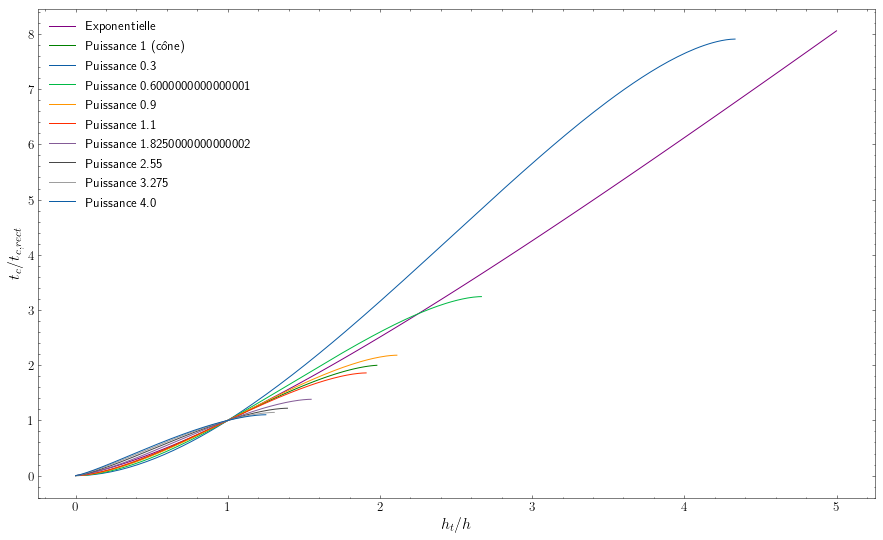

In [47]:
with plt.style.context('science'):
    
    h = 7e-3
    
    b = np.concatenate((np.linspace(0.3,0.9, 3), np.linspace(1.1, 4, 5)))
    
    D = 6.9e-9*110
    
    lam = []
    beta = []

    plt.figure(figsize=[15,9])
    
    z_exp = np.concatenate((np.linspace(0, h-1e-7, 25),np.linspace(h+1e-7, 5*h, 75)))
    z_cone = np.concatenate((np.linspace(0, h-1e-7, 50), np.linspace(h+1e-7, 2*h, 50)))
    
    for i in range(len(z_exp)):
        lam.append(find_lamb_exp(h, z_exp[i]))
        beta.append(find_beta_cone(h, z_cone[i]))
        
    lam = np.array(lam)
    beta = np.array(beta)
    
    t_exp = temps_exp(np.array(lam), z_exp)
    t_cone = temps_cone(np.array(beta), z_cone)
    
    plt.plot(z_exp/h, t_exp/(h**2/2), color='purple', label='Exponentielle')
    plt.plot(z_cone/h, t_cone/(h**2/2), color='green', label='Puissance 1 (cône)')

    for i in range(len(b)):
        h_limite = find_h_max(h, b[i], a0)
        z = np.linspace(0.000001, h_limite, 150)

        mu = []
        temps = []

        for j in range(len(z)):
            mu.append(find_mu(h, z[j], b[i]))
            temps.append(temps_congel(mu[j], b[i], z[j]))

        temps = np.array(temps)

        plt.plot(z/h, temps/(h**2/2), label=r'Puissance '+str(b[i]))

    plt.xlabel(r'$h_t/h$')
    plt.ylabel(r'$t_c/t_{c,rect}$')

    plt.legend()

# Zone $h_t/h<1$

/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-9-3ee7e10ebfe8>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2/(h_tronq**2)*(h-h_tronq)
<ipython-input-10-8f853763b2d1>:2: RuntimeWarning: invalid value encountered in multiply
  u = 1 + beta*h_tronq
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


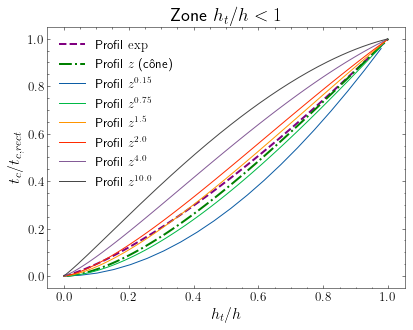

In [48]:
with plt.style.context('science'):
    
    b = np.array([0.15, 3/4, 1.5, 2, 4, 10])
    
    #b = np.concatenate((np.linspace(0.3,0.9, 2), np.linspace(1.1, 4, 3)))
    
    D = 6.9e-9*110
    
    lam = []
    beta = []

    plt.figure(figsize=[6.4,4.8])
    
    z_exp = np.concatenate((np.linspace(0, h-1e-7, 100),np.linspace(h+1e-7, 3*h, 100)))
    z_cone = np.concatenate((np.linspace(0, h-1e-7, 100), np.linspace(h+1e-7, 2*h, 100)))
    
    m_e = [value <=h for value in z_exp]
    m_c = [value <=h for value in z_cone]
    
    for i in range(len(z_exp)):
        lam.append(find_lamb_exp(h, z_exp[i]))
        
    for j in range(len(z_cone)):
        beta.append(find_beta_cone(h, z_cone[j]))
        
    lam = np.array(lam)
    beta = np.array(beta)
    
    t_exp = temps_exp(np.array(lam), z_exp)
    t_cone = temps_cone(np.array(beta), z_cone)
    
    plt.plot(z_exp[m_e]/h, t_exp[m_e]/(h**2/2), color='purple', label='Profil $\exp$', linestyle='--', linewidth=2)
    plt.plot(z_cone[m_c]/h, t_cone[m_c]/(h**2/2), color='green', label='Profil $z$ (cône)', linestyle='-.', linewidth=2)

    for i in range(len(b)):
        h_limite = find_h_max(h, b[i], a0)
        z = np.linspace(0.000001, h_limite, 150)
        
        mask = [value <= h for value in z]

        mu = []
        temps = []

        for j in range(len(z)):
            mu.append(find_mu(h, z[j], b[i]))
            temps.append(temps_congel(mu[j], b[i], z[j]))

        temps = np.array(temps)

        plt.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b[i],3))+'}$')

    plt.xlabel(r'$h_t/h$')
    plt.ylabel(r'$t_c/t_{c,rect}$')
    plt.title("Zone $h_t/h<1$")
        
    #plt.axvspan(1, 3, color='green', alpha=0.09, label=r'$h_t/h>1$')
    #plt.axvspan(0, 1, color='red', alpha=0.09, label=r'$h_t/h<1$')

    plt.legend()
    
    #plt.savefig("Zone_rap_inf_a_1.pdf")

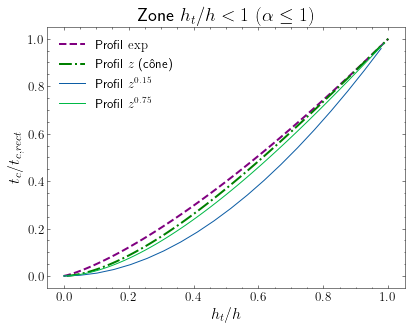

In [49]:
with plt.style.context('science'):
    plt.figure(figsize=(6.4, 4.8))  # Taille de la figure

    # Tracé de la deuxième figure
    plt.plot(z_exp[m_e]/h, t_exp[m_e]/(h**2/2), color='purple', label='Profil $\exp$', linestyle='--', linewidth=2)
    plt.plot(z_cone[m_c]/h, t_cone[m_c]/(h**2/2), color='green', label='Profil $z$ (cône)', linestyle='-.', linewidth=2)

    for i in range(len(b)):
        if b[i] <= 1:
            h_limite = find_h_max(h, b[i], a0)
            z = np.linspace(0.000001, h_limite, 150)
            mask = [value <= h for value in z]

            mu = []
            temps = []

            for j in range(len(z)):
                mu.append(find_mu(h, z[j], b[i]))
                temps.append(temps_congel(mu[j], b[i], z[j]))

            temps = np.array(temps)
            plt.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b[i],3))+'}$')

    # Paramètres de la deuxième figure
    plt.xlabel(r'$h_t/h$')
    plt.ylabel(r'$t_c/t_{c,rect}$')
    plt.title(r"Zone $h_t/h<1$ $(\alpha \leq 1)$")
    plt.legend()


    plt.savefig('fig2.pdf')


/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-9-3ee7e10ebfe8>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2/(h_tronq**2)*(h-h_tronq)
<ipython-input-10-8f853763b2d1>:2: RuntimeWarning: invalid value encountered in multiply
  u = 1 + beta*h_tronq
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


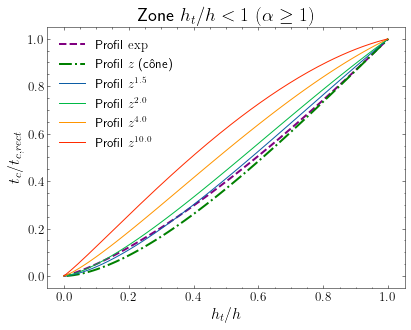

In [50]:
with plt.style.context('science'):
    b = np.array([0.15, 1/2, 3/4, 1.5, 2, 4, 10])
    D = 6.9e-9*110

    lam = []
    beta = []

    plt.figure(figsize=(6.4, 4.8))  # Taille de la figure

    z_exp = np.concatenate((np.linspace(0, h-1e-7, 100), np.linspace(h+1e-7, 3*h, 100)))
    z_cone = np.concatenate((np.linspace(0, h-1e-7, 100), np.linspace(h+1e-7, 2*h, 100)))

    m_e = [value <= h for value in z_exp]
    m_c = [value <= h for value in z_cone]

    for i in range(len(z_exp)):
        lam.append(find_lamb_exp(h, z_exp[i]))

    for j in range(len(z_cone)):
        beta.append(find_beta_cone(h, z_cone[j]))

    lam = np.array(lam)
    beta = np.array(beta)

    t_exp = temps_exp(np.array(lam), z_exp)
    t_cone = temps_cone(np.array(beta), z_cone)

    # Tracé de la première figure
    plt.plot(z_exp[m_e]/h, t_exp[m_e]/(h**2/2), color='purple', label='Profil $\exp$', linestyle='--', linewidth=2)
    plt.plot(z_cone[m_c]/h, t_cone[m_c]/(h**2/2), color='green', label='Profil $z$ (cône)', linestyle='-.', linewidth=2)

    for i in range(len(b)):
        if b[i] > 1:
            h_limite = find_h_max(h, b[i], a0)
            z = np.linspace(0.000001, h_limite, 150)
            mask = [value <= h for value in z]

            mu = []
            temps = []

            for j in range(len(z)):
                mu.append(find_mu(h, z[j], b[i]))
                temps.append(temps_congel(mu[j], b[i], z[j]))

            temps = np.array(temps)
            plt.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b[i],3))+'}$')

    # Paramètres de la première figure
    plt.xlabel(r'$h_t/h$')
    plt.ylabel(r'$t_c/t_{c,rect}$')
    plt.title(r"Zone $h_t/h<1$ $(\alpha \geq 1)$")
    plt.legend()

    plt.savefig("fig1.pdf")


Donc seules les puissances supérieures ou égales à 1 sont meilleures que l'exponentielle sur toute leur plage

# Zone $h_t/h>1$ 

/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-9-3ee7e10ebfe8>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2/(h_tronq**2)*(h-h_tronq)
<ipython-input-10-8f853763b2d1>:2: RuntimeWarning: invalid value encountered in multiply
  u = 1 + beta*h_tronq
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


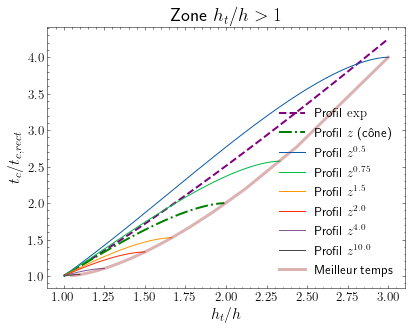

In [53]:
with plt.style.context('science'):
    
    b = np.array([1/2, 3/4, 1.5, 2, 4, 10])
    
    #b = np.concatenate((np.linspace(0.3,0.9, 2), np.linspace(1.1, 4, 3)))
    
    D = 6.9e-9*110
    
    lam = []
    beta = []

    plt.figure(figsize=[6.4,4.8])
    
    z_exp = np.concatenate((np.linspace(0, h-1e-7, 100),np.linspace(h+1e-7, 3*h, 100)))
    z_cone = np.concatenate((np.linspace(0, h-1e-7, 100), np.linspace(h+1e-7, 2*h, 100)))
    
    m_e = [value >=h for value in z_exp]
    m_c = [value >=h for value in z_cone]
    
    for i in range(len(z_exp)):
        lam.append(find_lamb_exp(h, z_exp[i]))
        
    for j in range(len(z_cone)):
        beta.append(find_beta_cone(h, z_cone[j]))
        
    lam = np.array(lam)
    beta = np.array(beta)
    
    t_exp = temps_exp(np.array(lam), z_exp)
    t_cone = temps_cone(np.array(beta), z_cone)
    
    plt.plot(z_exp[m_e]/h, t_exp[m_e]/(h**2/2), color='purple', label='Profil $\exp$', linestyle='--', linewidth=2)
    plt.plot(z_cone[m_c]/h, t_cone[m_c]/(h**2/2), color='green', label='Profil $z$ (cône)', linestyle='-.', linewidth=2)

    for i in range(len(b)):
        h_limite = find_h_max(h, b[i], a0)
        z = np.linspace(0.000001, h_limite, 150)
        
        mask = [value >= h for value in z]

        mu = []
        temps = []

        for j in range(len(z)):
            mu.append(find_mu(h, z[j], b[i]))
            temps.append(temps_congel(mu[j], b[i], z[j]))

        temps = np.array(temps)

        plt.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b[i],3))+'}$')

    """Courbe du meilleur temps"""
    
    b = np.linspace(0.5, 20, 100)
    h_b = f_h_max_vect(7e-3, b, 4e-3) #hauteux max a la puissance b

    Y = tc_level_vect(b, h_b)/(h**2/2) #calcul du temps par la puiss b à la hauteur max de puiss b
    plt.plot(h_b/h, Y, color='darkred', linewidth=3, label='Meilleur temps', alpha=0.3)
        
    plt.xlabel(r'$h_t/h$')
    plt.ylabel(r'$t_c/t_{c,rect}$')
    plt.title("Zone $h_t/h>1$")
        
    #plt.axvspan(1, 3, color='green', alpha=0.09, label=r'$h_t/h>1$')
    #plt.axvspan(0, 1, color='red', alpha=0.09, label=r'$h_t/h<1$')

    plt.legend()
    
    #plt.savefig("Zone_rap_sup_a_1.pdf")

/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-9-3ee7e10ebfe8>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2/(h_tronq**2)*(h-h_tronq)
<ipython-input-10-8f853763b2d1>:2: RuntimeWarning: invalid value encountered in multiply
  u = 1 + beta*h_tronq


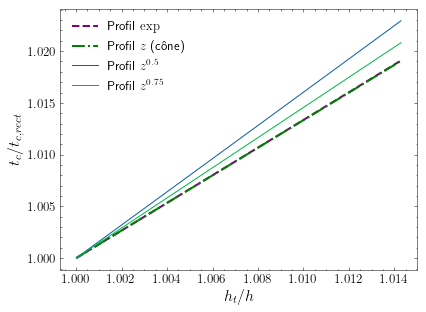

In [54]:
with plt.style.context('science'):
    
    b = np.array([1/2, 3/4])
    
    #b = np.concatenate((np.linspace(0.3,0.9, 2), np.linspace(1.1, 4, 3)))
    
    D = 6.9e-9*110
    
    lam = []
    beta = []

    plt.figure(figsize=[6.4,4.8])
    
    z_exp = np.concatenate((np.linspace(0, h-1e-7, 100),np.linspace(h+1e-7, h+1e-4, 100)))
    z_cone = np.concatenate((np.linspace(0, h-1e-7, 100), np.linspace(h+1e-7, h+1e-4, 100)))
    
    m_e = [value >=h for value in z_exp]
    m_c = [value >=h for value in z_cone]
    
    for i in range(len(z_exp)):
        lam.append(find_lamb_exp(h, z_exp[i]))
        
    for j in range(len(z_cone)):
        beta.append(find_beta_cone(h, z_cone[j]))
        
    lam = np.array(lam)
    beta = np.array(beta)
    
    t_exp = temps_exp(np.array(lam), z_exp)
    t_cone = temps_cone(np.array(beta), z_cone)
    
    plt.plot(z_exp[m_e]/h, t_exp[m_e]/(h**2/2), color='purple', label='Profil $\exp$', linestyle='--', linewidth=2)
    plt.plot(z_cone[m_c]/h, t_cone[m_c]/(h**2/2), color='green', label='Profil $z$ (cône)', linestyle='-.', linewidth=2)

    for i in range(len(b)):
        h_limite = find_h_max(h, b[i], a0)
        z = np.linspace(h+1e-7, h+1e-4, 100)
        
        mask = [value >= h for value in z]

        mu = []
        temps = []

        for j in range(len(z)):
            mu.append(find_mu(h, z[j], b[i]))
            temps.append(temps_congel(mu[j], b[i], z[j]))

        temps = np.array(temps)

        plt.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b[i],3))+'}$')

    plt.xlabel(r'$h_t/h$')
    plt.ylabel(r'$t_c/t_{c,rect}$')
    #plt.title("Zone $h_t/h<1$")
        
    #plt.axvspan(1, 3, color='green', alpha=0.09, label=r'$h_t/h>1$')
    #plt.axvspan(0, 1, color='red', alpha=0.09, label=r'$h_t/h<1$')

    plt.legend()
    
    #plt.savefig("Zone_rap_sup_a_1_zoom.pdf")

## Contour plot : $t_c, h_t/h, \alpha$

Objectif : tracer un contour plot avec :
- Axe X : $h_t/h$
- Axe Y : $t_c$
- Level : Puissance $\alpha$

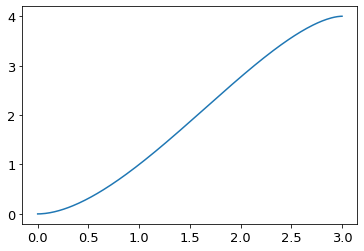

In [55]:
h = 7e-3
Dt_rect = h**2/2

# Étape 1 : Créer une grille de valeurs pour x et b
h_t_values = np.linspace(1e-6, 3*h, 200)  # Définir la plage et le nombre de points pour x
b_values = np.linspace(0.5, 0.9, 200)  # Définir la plage et le nombre de points pour b

plt.plot(h_t_values/h, tc_level_vect(0.5, h_t_values)/Dt_rect)


/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-9-3ee7e10ebfe8>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2/(h_tronq**2)*(h-h_tronq)
<ipython-input-10-8f853763b2d1>:2: RuntimeWarning: invalid value encountered in multiply
  u = 1 + beta*h_tronq
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


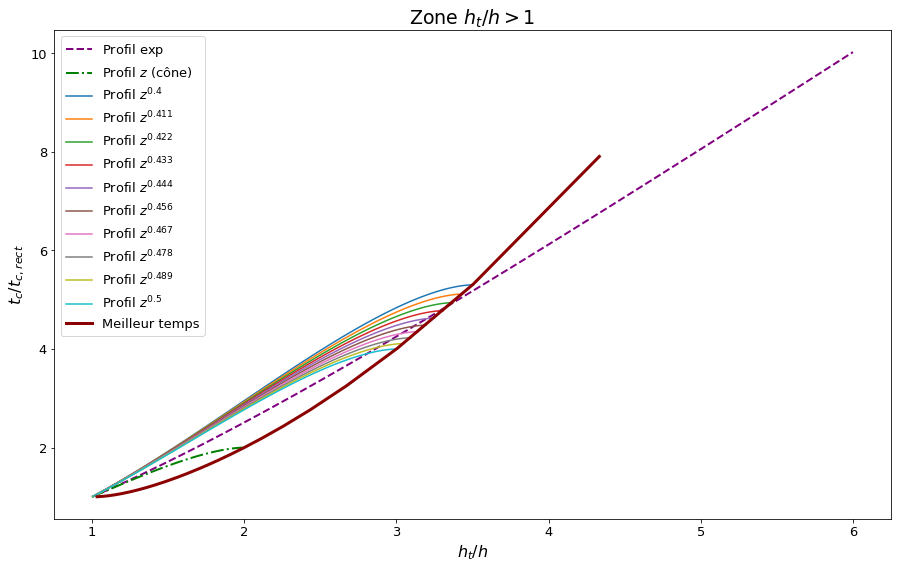

In [57]:
h = 7e-3
    
b = np.linspace(0.4, 0.5, 10)

#b = np.concatenate((np.linspace(0.3,0.9, 2), np.linspace(1.1, 4, 3)))

D = 6.9e-9*110

lam = []
beta = []

plt.figure(figsize=[15,9])

z_exp = np.concatenate((np.linspace(0, h-1e-7, 100),np.linspace(h+1e-7, 6*h, 400)))
z_cone = np.concatenate((np.linspace(0, h-1e-7, 100), np.linspace(h+1e-7, 2*h, 100)))

m_e = [value >=h for value in z_exp]
m_c = [value >=h for value in z_cone]

for i in range(len(z_exp)):
    lam.append(find_lamb_exp(h, z_exp[i]))

for j in range(len(z_cone)):
    beta.append(find_beta_cone(h, z_cone[j]))

lam = np.array(lam)
beta = np.array(beta)

t_exp = temps_exp(np.array(lam), z_exp)
t_cone = temps_cone(np.array(beta), z_cone)

plt.plot(z_exp[m_e]/h, t_exp[m_e]/(h**2/2), color='purple', label='Profil $\exp$', linestyle='--', linewidth=2)
plt.plot(z_cone[m_c]/h, t_cone[m_c]/(h**2/2), color='green', label='Profil $z$ (cône)', linestyle='-.', linewidth=2)

for i in range(len(b)):
    h_limite = find_h_max(h, b[i], a0)
    z = np.linspace(0.000001, h_limite, 150)

    mask = [value >= h for value in z]

    mu = []
    temps = []

    for j in range(len(z)):
        mu.append(find_mu(h, z[j], b[i]))
        temps.append(temps_congel(mu[j], b[i], z[j]))

    temps = np.array(temps)

    plt.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b[i],3))+'}$')

"""Courbe du meilleur temps"""

b = np.linspace(0.3, 30, 300)
h_b = f_h_max_vect(h, b, 4e-3) #hauteux max a la puissance b

Y = tc_level_vect(b, h_b, h=7e-3)/(h**2/2) #calcul du temps par la puiss b à la hauteur max de puiss b
plt.plot(h_b/h, Y, color='darkred', linewidth=3, label='Meilleur temps', alpha=1)

plt.xlabel(r'$h_t/h$')
plt.ylabel(r'$t_c/t_{c,rect}$')
plt.title("Zone $h_t/h>1$")

#plt.axvspan(1, 3, color='green', alpha=0.09, label=r'$h_t/h>1$')
#plt.axvspan(0, 1, color='red', alpha=0.09, label=r'$h_t/h<1$')

plt.legend()

#plt.savefig("Zone_rap_sup_a_1.pdf")

**Problème** A un certain rapport géométrique, l'exponentielle passe devant. Il faudrait trouver la valeur de ce rapport. Impossible analytiquement, on va le faire numériquement.

In [58]:
def over_under(b):
    h = 7e-3
    a0 = 4e-3
    
    """Temps pour la loi de puissance"""
    
    h_b = f_h_max_vect(h, b, a0)
    
    mu = find_mu(h, h_b, b)
    
    temps_puissance = temps_congel(mu, b, h_b)
    
    """Temps pour l'exponentielle"""
    
    lam = find_lamb_exp(h, h_b)
    
    temps_expo = temps_exp(lam, h_b)
    
    """Resultat"""
    
    return temps_puissance - temps_expo

In [59]:
over_under(0.43)

-6.347097166043141e-07

In [60]:
b_to_try = np.linspace(0.4242, 0.42423772173356905, 100)

for x in b_to_try:
    if over_under(x) <= 0:
        print(x)
        
        """Calcul du rapport associé"""
        
        print("Rapport critique :", f_h_max_vect(h, x, a0)/h)
        
        break

0.42423772173356905
Rapport critique : 3.357168985285299


**RAPPORT CRITIQUE** : $h_t/h=3.357$

/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-9-3ee7e10ebfe8>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2/(h_tronq**2)*(h-h_tronq)
<ipython-input-10-8f853763b2d1>:2: RuntimeWarning: invalid value encountered in multiply
  u = 1 + beta*h_tronq
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


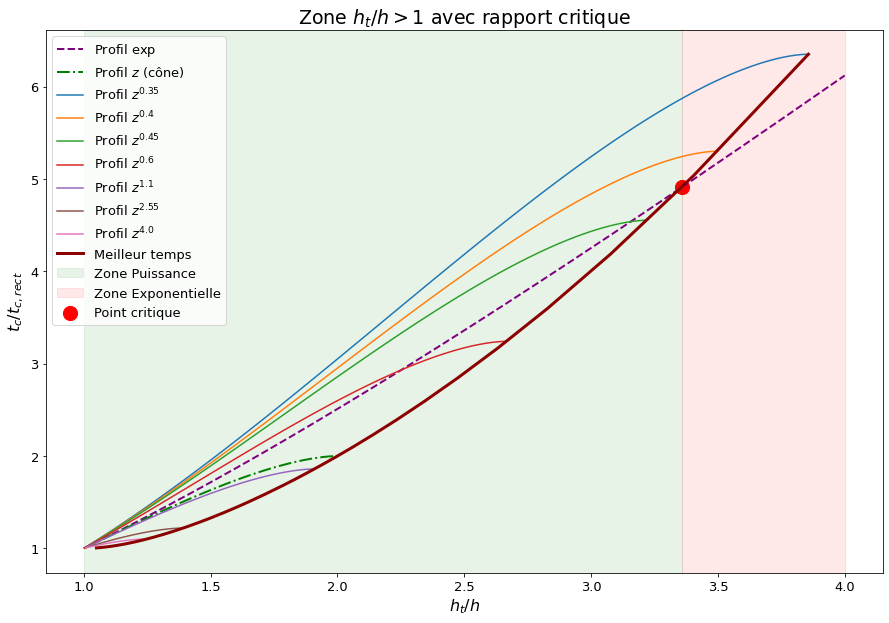

In [61]:
h = 7e-3

b = np.concatenate((np.array([0.35, 0.4, 0.45, 0.6]), np.linspace(1.1, 4, 3)))

D = 6.9e-9*110

lam = []
beta = []

plt.figure(figsize=[15,10])

z_exp = np.concatenate((np.linspace(0, h-1e-7, 100),np.linspace(h+1e-7, 4*h, 400)))
z_cone = np.concatenate((np.linspace(0, h-1e-7, 100), np.linspace(h+1e-7, 2*h, 100)))

m_e = [value >=h for value in z_exp]
m_c = [value >=h for value in z_cone]

for i in range(len(z_exp)):
    lam.append(find_lamb_exp(h, z_exp[i]))

for j in range(len(z_cone)):
    beta.append(find_beta_cone(h, z_cone[j]))

lam = np.array(lam)
beta = np.array(beta)

t_exp = temps_exp(np.array(lam), z_exp)
t_cone = temps_cone(np.array(beta), z_cone)

plt.plot(z_exp[m_e]/h, t_exp[m_e]/(h**2/2), color='purple', label='Profil $\exp$', linestyle='--', linewidth=2)
plt.plot(z_cone[m_c]/h, t_cone[m_c]/(h**2/2), color='green', label='Profil $z$ (cône)', linestyle='-.', linewidth=2)

for i in range(len(b)):
    h_limite = find_h_max(h, b[i], a0)
    z = np.linspace(0.000001, h_limite, 150)

    mask = [value >= h for value in z]

    mu = []
    temps = []

    for j in range(len(z)):
        mu.append(find_mu(h, z[j], b[i]))
        temps.append(temps_congel(mu[j], b[i], z[j]))

    temps = np.array(temps)

    plt.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b[i],3))+'}$')

"""Courbe du meilleur temps"""

b = np.linspace(0.35, 20, 300)
h_b = f_h_max_vect(h, b, 4e-3) #hauteux max a la puissance b

Y = tc_level_vect(b, h_b, h=7e-3)/(h**2/2) #calcul du temps par la puiss b à la hauteur max de puiss b
plt.plot(h_b/h, Y, color='darkred', linewidth=3, label='Meilleur temps', alpha=1)


plt.scatter([3.357168985285299], [tc_level_vect(0.42423772173356905, 3.357168985285299*h)/(h**2/2)], s=200, color='red', label='Point critique')



plt.xlabel(r'$h_t/h$')
plt.ylabel(r'$t_c/t_{c,rect}$')
plt.title("Zone $h_t/h>1$ avec rapport critique")


plt.axvspan(1, 3.357168985285299, color='green', alpha=0.09, label=r'Zone Puissance')
plt.axvspan(3.357168985285299, 4, color='red', alpha=0.09, label=r'Zone Exponentielle')

plt.legend()

#plt.savefig("Zones_critiques.pdf")

/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-9-3ee7e10ebfe8>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2/(h_tronq**2)*(h-h_tronq)
<ipython-input-10-8f853763b2d1>:2: RuntimeWarning: invalid value encountered in multiply
  u = 1 + beta*h_tronq
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


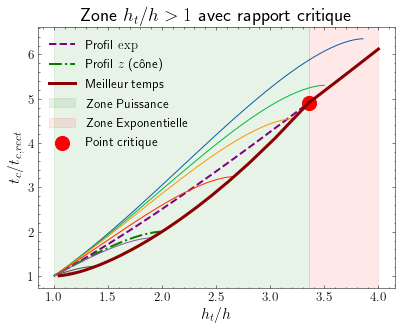

In [62]:
with plt.style.context('science'):
    h = 7e-3



    b = np.concatenate((np.array([0.35, 0.4, 0.45, 0.6]), np.linspace(1.1, 4, 3)))

    D = 6.9e-9*110

    lam2 = []
    lam = []
    beta = []

    plt.figure(figsize=[6.4,4.8])

    z_exp2 = np.linspace(3.357168985285299, 4, 100)*h
    z_exp = np.concatenate((np.linspace(0, h-1e-7, 100),np.linspace(h+1e-7, 4*h, 400)))
    z_cone = np.concatenate((np.linspace(0, h-1e-7, 100), np.linspace(h+1e-7, 2*h, 100)))

    m_e = [value >=h for value in z_exp]
    m_c = [value >=h for value in z_cone]

    for i in range(len(z_exp)):
        lam.append(find_lamb_exp(h, z_exp[i]))

    for j in range(len(z_cone)):
        beta.append(find_beta_cone(h, z_cone[j]))

    for k in range(len(z_exp2)):
        lam2.append(find_lamb_exp(h, z_exp2[k]))

    lam = np.array(lam)
    beta = np.array(beta)
    lam2 = np.array(lam2)

    t_exp = temps_exp(np.array(lam), z_exp)
    t_exp2 = temps_exp(np.array(lam2), z_exp2)
    t_cone = temps_cone(np.array(beta), z_cone)

    plt.plot(z_exp[m_e]/h, t_exp[m_e]/(h**2/2), color='purple', label='Profil $\exp$', linestyle='--', linewidth=2)
    plt.plot(z_cone[m_c]/h, t_cone[m_c]/(h**2/2), color='green', label='Profil $z$ (cône)', linestyle='-.', linewidth=2)

    for i in range(len(b)):
        h_limite = find_h_max(h, b[i], a0)
        z = np.linspace(0.000001, h_limite, 150)

        mask = [value >= h for value in z]

        mu = []
        temps = []

        for j in range(len(z)):
            mu.append(find_mu(h, z[j], b[i]))
            temps.append(temps_congel(mu[j], b[i], z[j]))

        temps = np.array(temps)

        plt.plot(z[mask]/h, temps[mask]/(h**2/2))

    """Courbe du meilleur temps"""

    b = np.linspace(0.42423772173356905, 20, 300)
    h_b = f_h_max_vect(h, b, 4e-3) #hauteux max a la puissance b

    Y = tc_level_vect(b, h_b, h=7e-3)/(h**2/2) #calcul du temps par la puiss b à la hauteur max de puiss b
    plt.plot(h_b/h, Y, color='darkred', linewidth=3, label='Meilleur temps', alpha=1)
    plt.plot(z_exp2/h, t_exp2/(h**2/2), linewidth=3, alpha=1, color='darkred')

    plt.scatter([3.357168985285299], [tc_level_vect(0.42423772173356905, 3.357168985285299*h)/(h**2/2)], s=200, color='red', label='Point critique')



    plt.xlabel(r'$h_t/h$')
    plt.ylabel(r'$t_c/t_{c,rect}$')
    plt.title("Zone $h_t/h>1$ avec rapport critique")


    plt.axvspan(1, 3.357168985285299, color='green', alpha=0.09, label=r'Zone Puissance')
    plt.axvspan(3.357168985285299, 4, color='red', alpha=0.09, label=r'Zone Exponentielle')

    plt.legend()

    plt.savefig("Zones_critiques_format.pdf")

/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-9-3ee7e10ebfe8>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2/(h_tronq**2)*(h-h_tronq)
<ipython-input-10-8f853763b2d1>:2: RuntimeWarning: invalid value encountered in multiply
  u = 1 + beta*h_tronq
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


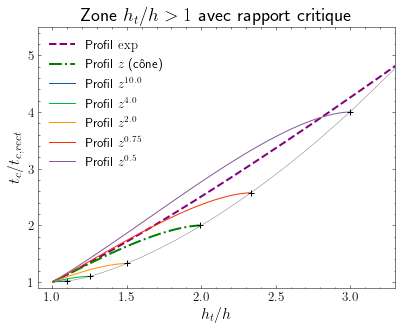

In [63]:
with plt.style.context('science'):
    h = 7e-3



    b = np.array([10, 4, 2, 0.75, 0.5])

    D = 6.9e-9*110

    lam2 = []
    lam = []
    beta = []

    plt.figure(figsize=[6.4,4.8])

    z_exp2 = np.linspace(3.357168985285299, 4, 100)*h
    z_exp = np.concatenate((np.linspace(0, h-1e-7, 100),np.linspace(h+1e-7, 4*h, 400)))
    z_cone = np.concatenate((np.linspace(0, h-1e-7, 100), np.linspace(h+1e-7, 2*h, 100)))

    m_e = [value >=h for value in z_exp]
    m_c = [value >=h for value in z_cone]

    for i in range(len(z_exp)):
        lam.append(find_lamb_exp(h, z_exp[i]))

    for j in range(len(z_cone)):
        beta.append(find_beta_cone(h, z_cone[j]))

    for k in range(len(z_exp2)):
        lam2.append(find_lamb_exp(h, z_exp2[k]))

    lam = np.array(lam)
    beta = np.array(beta)
    lam2 = np.array(lam2)

    t_exp = temps_exp(np.array(lam), z_exp)
    t_exp2 = temps_exp(np.array(lam2), z_exp2)
    t_cone = temps_cone(np.array(beta), z_cone)

    plt.plot(z_exp[m_e]/h, t_exp[m_e]/(h**2/2), color='purple', label='Profil $\exp$', linestyle='--', linewidth=2)
    plt.plot(z_cone[m_c]/h, t_cone[m_c]/(h**2/2), color='green', label='Profil $z$ (cône)', linestyle='-.', linewidth=2)
    
    plt.plot([z_cone[-2]/h], [t_cone[-2]/(h**2/2)],'+',color='black')

    for i in range(len(b)):
        h_limite = find_h_max(h, b[i], a0)
        z = np.linspace(0.000001, h_limite, 150)

        mask = [value >= h for value in z]

        mu = []
        temps = []

        for j in range(len(z)):
            mu.append(find_mu(h, z[j], b[i]))
            temps.append(temps_congel(mu[j], b[i], z[j]))

        temps = np.array(temps)

        plt.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b[i],3))+'}$')
        plt.plot([h_limite/h], [temps_congel(find_mu(h, h_limite, b[i]), b[i], h_limite)/(h**2/2)], '+', color='black', linewidth=2)

    """Courbe du meilleur temps"""

    b = np.linspace(0.3, 20, 300)
    h_b = f_h_max_vect(h, b, 4e-3) #hauteux max a la puissance b

    Y = tc_level_vect(b, h_b, h=7e-3)/(h**2/2) #calcul du temps par la puiss b à la hauteur max de puiss b
    plt.plot(h_b/h, Y, color='black', linewidth=0.5, alpha=0.5)
    #plt.plot(z_exp2/h, t_exp2/(h**2/2), linewidth=3, alpha=1, color='darkred')

    #plt.scatter([3.357168985285299], [tc_level_vect(0.42423772173356905, 3.357168985285299*h)/(h**2/2)], s=200, color='red', label='Point critique')



    plt.xlabel(r'$h_t/h$')
    plt.ylabel(r'$t_c/t_{c,rect}$')
    plt.title("Zone $h_t/h>1$ avec rapport critique")


    plt.xlim(0.9, 3.3)
    plt.ylim(0.9, 5.5)
    
    #plt.axvspan(1, 3.357168985285299, color='green', alpha=0.09, label=r'Zone Puissance')
    #plt.axvspan(3.357168985285299, 4, color='red', alpha=0.09, label=r'Zone Exponentielle')

    plt.legend()

    plt.savefig("Zones_critiques_format.pdf")

<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in divide
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


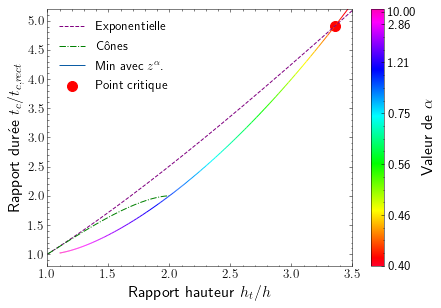

In [65]:

from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d

with plt.style.context('science'):

    # Vos calculs existants (je suppose que toutes les fonctions nécessaires sont définies)
    b = np.concatenate((np.linspace(0.4, 1.1, 100), np.linspace(1.1, 10, 200)))
    h_b = f_h_max_vect(7e-3, b, 4e-3)
    Y = tc_level_vect(b, h_b)/(h**2/2)
    X = h_b/h

    # Calcul de la longueur cumulée de la courbe
    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cumulative_length = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=2)).ravel())
    normalized_length = np.insert(cumulative_length, 0, 0) / cumulative_length[-1]

    # Création de la figure avec une taille spécifique
    fig, ax = plt.subplots(figsize=(6.4, 4.5))  # Changez les dimensions selon vos besoins

    # Création de la LineCollection avec la longueur normalisée
    lc = LineCollection(segments, cmap='gist_rainbow', label=r'Min avec $z^\alpha$.')
    lc.set_array(normalized_length[:-1])
    ax.add_collection(lc)

    # Ajout d'une barre de couleur personnalisée
    cbar = plt.colorbar(lc)
    cbar.set_label(r'Valeur de $\alpha$')

    # Création d'une fonction d'interpolation pour mapper la longueur normalisée aux valeurs de b
    length_to_b = interp1d(normalized_length, b)

    # Personnalisation des ticks de la colorbar
    num_ticks = 7
    tick_locations = np.array([0., 0.198, 0.396, 0.594, 0.792, 0.94, 0.99])
    tick_labels = [f"{length_to_b(loc):.2f}" for loc in tick_locations]
    tick_labels[-1] = "10.00"  # Forcer la dernière valeur à 10.00
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)

    # Traçage de l'exponentielle
    ht_values = np.linspace(1+1e-6, 3.5, 220)*h

    ht_cone = np.linspace(1, 2, 300)*h

    lam = []
    beta = []
    for i in range(len(ht_values)):
        lam.append(find_lamb_exp(h, ht_values[i]))
    for i in range(len(ht_cone)):
        beta.append(find_beta_cone(h,ht_cone[i]))

    lam = np.array(lam)
    beta = np.array(beta)

    t_exp = temps_exp(np.array(lam), ht_values)
    t_cone = temps_cone(np.array(beta), ht_cone)

    ax.plot(ht_values/h, t_exp/(h**2/2), color='purple', label='Exponentielle', linestyle='--')
    ax.plot(ht_cone/h, t_cone/(h**2/2), color='green', label='Cônes', linestyle='-.')
    
    ax.scatter([3.357168985285299], [tc_level_vect(0.42423772173356905, 3.357168985285299*h)/(h**2/2)], s=100, color='red', label='Point critique')

    # Définition des limites des axes
    ax.set_xlim(1, 3.5)  # Ajustez selon vos besoins
    ax.set_ylim(0.8, 5.2)  # Ajustez selon vos besoins

    # Étiquettes des axes
    ax.set_xlabel(r'Rapport hauteur $h_t/h$')
    ax.set_ylabel(r'Rapport durée $t_c/t_{c,rect}$')

    # Affichage de la légende
    ax.legend()

    # Ajustement automatique de la mise en page
    plt.tight_layout()

    #plt.savefig("Cmap_puissance_critique.pdf")

<ipython-input-8-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in divide
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-8-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-8-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


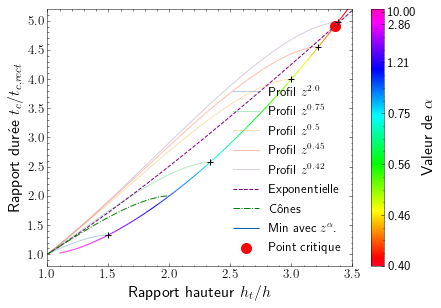

In [43]:

from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d

with plt.style.context('science'):

    # Vos calculs existants (je suppose que toutes les fonctions nécessaires sont définies)
    b2 = np.array([2, 0.75, 0.5, 0.45, 0.42])
    b = np.concatenate((np.linspace(0.4, 1.1, 100), np.linspace(1.1, 10, 200)))
    h_b = f_h_max_vect(7e-3, b, 4e-3)
    Y = tc_level_vect(b, h_b)/(h**2/2)
    X = h_b/h

    # Calcul de la longueur cumulée de la courbe
    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cumulative_length = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=2)).ravel())
    normalized_length = np.insert(cumulative_length, 0, 0) / cumulative_length[-1]

    # Création de la figure avec une taille spécifique
    fig, ax = plt.subplots(figsize=(6.4, 4.5))  # Changez les dimensions selon vos besoins

    # Création de la LineCollection avec la longueur normalisée
    lc = LineCollection(segments, cmap='gist_rainbow', label=r'Min avec $z^\alpha$.')
    lc.set_array(normalized_length[:-1])
    ax.add_collection(lc)

    # Ajout d'une barre de couleur personnalisée
    cbar = plt.colorbar(lc)
    cbar.set_label(r'Valeur de $\alpha$')

    # Création d'une fonction d'interpolation pour mapper la longueur normalisée aux valeurs de b
    length_to_b = interp1d(normalized_length, b)

    # Personnalisation des ticks de la colorbar
    num_ticks = 7
    tick_locations = np.array([0., 0.198, 0.396, 0.594, 0.792, 0.94, 0.99])
    tick_labels = [f"{length_to_b(loc):.2f}" for loc in tick_locations]
    tick_labels[-1] = "10.00"  # Forcer la dernière valeur à 10.00
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)

    # Traçage de l'exponentielle
    ht_values = np.linspace(1+1e-6, 3.5, 220)*h

    ht_cone = np.linspace(1, 2, 300)*h

    lam = []
    beta = []
    for i in range(len(ht_values)):
        lam.append(find_lamb_exp(h, ht_values[i]))
    for i in range(len(ht_cone)):
        beta.append(find_beta_cone(h,ht_cone[i]))

        
    for i in range(len(b2)):
        h_limite = find_h_max(h, b2[i], a0)
        z = np.linspace(0.000001, h_limite, 150)

        mask = [value >= h for value in z]

        mu = []
        temps = []

        for j in range(len(z)):
            mu.append(find_mu(h, z[j], b2[i]))
            temps.append(temps_congel(mu[j], b2[i], z[j]))

        temps = np.array(temps)

        ax.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b2[i],3))+'}$', alpha=0.3)
        ax.plot([h_limite/h], [temps_congel(find_mu(h, h_limite, b2[i]), b2[i], h_limite)/(h**2/2)], '+', color='black', linewidth=2)    
        
    lam = np.array(lam)
    beta = np.array(beta)

    t_exp = temps_exp(np.array(lam), ht_values)
    t_cone = temps_cone(np.array(beta), ht_cone)

    ax.plot(ht_values/h, t_exp/(h**2/2), color='purple', label='Exponentielle', linestyle='--')
    ax.plot(ht_cone/h, t_cone/(h**2/2), color='green', label='Cônes', linestyle='-.')
    
    ax.scatter([3.357168985285299], [tc_level_vect(0.42423772173356905, 3.357168985285299*h)/(h**2/2)], s=100, color='red', label='Point critique')

    # Définition des limites des axes
    ax.set_xlim(1, 3.5)  # Ajustez selon vos besoins
    ax.set_ylim(0.8, 5.2)  # Ajustez selon vos besoins

    # Étiquettes des axes
    ax.set_xlabel(r'Rapport hauteur $h_t/h$')
    ax.set_ylabel(r'Rapport durée $t_c/t_{c,rect}$')

    # Affichage de la légende
    ax.legend()

    # Ajustement automatique de la mise en page
    plt.tight_layout()

    #plt.savefig("Cmap_puissance_critique.pdf")

<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in divide
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


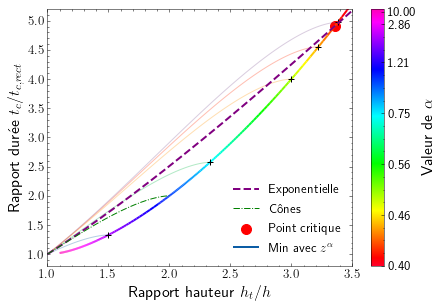

In [66]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d

with plt.style.context('science'):

    # Vos calculs existants (je suppose que toutes les fonctions nécessaires sont définies)
    b2 = np.array([2, 0.75, 0.5, 0.45, 0.42])
    b = np.concatenate((np.linspace(0.4, 1.1, 100), np.linspace(1.1, 10, 200)))
    h_b = f_h_max_vect(7e-3, b, 4e-3)
    Y = tc_level_vect(b, h_b)/(h**2/2)
    X = h_b/h

    # Calcul de la longueur cumulée de la courbe
    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cumulative_length = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=2)).ravel())
    normalized_length = np.insert(cumulative_length, 0, 0) / cumulative_length[-1]

    # Création de la figure avec une taille spécifique
    fig, ax = plt.subplots(figsize=(6.4, 4.5))  # Changez les dimensions selon vos besoins

    # Création de la LineCollection avec la longueur normalisée
    lc = LineCollection(segments, cmap='gist_rainbow', label=r'Min avec $z^\alpha$', linewidth=2)
    lc.set_array(normalized_length[:-1])
    ax.add_collection(lc)

    # Ajout d'une barre de couleur personnalisée
    cbar = plt.colorbar(lc)
    cbar.set_label(r'Valeur de $\alpha$')

    # Création d'une fonction d'interpolation pour mapper la longueur normalisée aux valeurs de b
    length_to_b = interp1d(normalized_length, b)

    # Personnalisation des ticks de la colorbar
    num_ticks = 7
    tick_locations = np.array([0., 0.198, 0.396, 0.594, 0.792, 0.94, 0.99])
    tick_labels = [f"{length_to_b(loc):.2f}" for loc in tick_locations]
    tick_labels[-1] = "10.00"  # Forcer la dernière valeur à 10.00
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)

    # Traçage de l'exponentielle
    ht_values = np.linspace(1+1e-6, 3.5, 220)*h

    ht_cone = np.linspace(1, 2, 300)*h

    lam = []
    beta = []
    for i in range(len(ht_values)):
        lam.append(find_lamb_exp(h, ht_values[i]))
    for i in range(len(ht_cone)):
        beta.append(find_beta_cone(h,ht_cone[i]))

    handles_p = []
    
    for i in range(len(b2)):
        h_limite = find_h_max(h, b2[i], a0)
        z = np.linspace(0.000001, h_limite, 150)

        mask = [value >= h for value in z]

        mu = []
        temps = []

        for j in range(len(z)):
            mu.append(find_mu(h, z[j], b2[i]))
            temps.append(temps_congel(mu[j], b2[i], z[j]))

        temps = np.array(temps)

        # Traçage des courbes individuelles avec les profils
        curve_line =ax.plot(z[mask]/h, temps[mask]/(h**2/2), label=r'Profil $z^{'+str(round(b2[i],3))+'}$', alpha=0.3)
        ax.plot([h_limite/h], [temps_congel(find_mu(h, h_limite, b2[i]), b2[i], h_limite)/(h**2/2)], '+', color='black', linewidth=2)
        #handles_p.append(curve_line)
        
    lam = np.array(lam)
    beta = np.array(beta)

    t_exp = temps_exp(np.array(lam), ht_values)
    t_cone = temps_cone(np.array(beta), ht_cone)

    # Traçage des courbes générales
    exp_line, = ax.plot(ht_values/h, t_exp/(h**2/2), color='purple', label='Exponentielle', linestyle='--', linewidth=2)
    cone_line, = ax.plot(ht_cone/h, t_cone/(h**2/2), color='green', label='Cônes', linestyle='-.')

    critical_point = ax.scatter([3.357168985285299], [tc_level_vect(0.42423772173356905, 3.357168985285299*h)/(h**2/2)], s=100, color='red', label='Point critique')

    # Définition des limites des axes
    ax.set_xlim(1, 3.5)  # Ajustez selon vos besoins
    ax.set_ylim(0.8, 5.2)  # Ajustez selon vos besoins

    # Étiquettes des axes
    ax.set_xlabel(r'Rapport hauteur $h_t/h$')
    ax.set_ylabel(r'Rapport durée $t_c/t_{c,rect}$')

    # Création de la première légende (courbes individuelles), en haut à gauche
    first_legend = ax.legend(handles = handles_p, loc='upper left', bbox_to_anchor=(0.0, 1.0))
    ax.add_artist(first_legend)  # On ajoute manuellement cette première légende

    # Création de la seconde légende (exponentielle, cônes, point critique), en bas à droite
    second_legend = ax.legend(handles=[exp_line, cone_line, critical_point, lc], loc='lower right')

    # Ajustement automatique de la mise en page
    plt.tight_layout()

    plt.savefig("Cmap_modif.pdf")


<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in divide
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-10-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


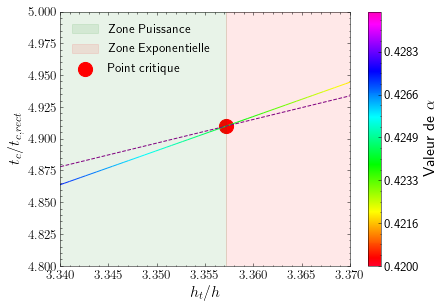

In [67]:

from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d

with plt.style.context('science'):

    # Vos calculs existants (je suppose que toutes les fonctions nécessaires sont définies)
    b = np.linspace(0.42, 0.43, 100)
    h_b = f_h_max_vect(7e-3, b, 4e-3)
    Y = tc_level_vect(b, h_b)/(h**2/2)
    X = h_b/h

    # Calcul de la longueur cumulée de la courbe
    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cumulative_length = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=2)).ravel())
    normalized_length = np.insert(cumulative_length, 0, 0) / cumulative_length[-1]

    # Création de la figure avec une taille spécifique
    fig, ax = plt.subplots(figsize=(6.4, 4.5))  # Changez les dimensions selon vos besoins
    
    plt.axvspan(1, 3.357168985285299, color='green', alpha=0.09, label=r'Zone Puissance')
    plt.axvspan(3.357168985285299, 4, color='red', alpha=0.09, label=r'Zone Exponentielle')

    # Création de la LineCollection avec la longueur normalisée
    lc = LineCollection(segments, cmap='gist_rainbow')
    lc.set_array(normalized_length[:-1])
    ax.add_collection(lc)

    # Ajout d'une barre de couleur personnalisée
    cbar = plt.colorbar(lc)
    cbar.set_label(r'Valeur de $\alpha$')

    # Création d'une fonction d'interpolation pour mapper la longueur normalisée aux valeurs de b
    length_to_b = interp1d(normalized_length, b)

    # Personnalisation des ticks de la colorbar
    num_ticks = 7
    tick_locations = np.linspace(0,1, num_ticks)
    tick_labels = [f"{length_to_b(loc):.4f}" for loc in tick_locations]
    tick_labels[-1] = np.max(b)  # Forcer la dernière valeur à 10.00
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)

    # Traçage de l'exponentielle
    ht_values = np.linspace(3.5, 3, 200)*h

    ht_cone = np.linspace(1, 2, 300)*h

    lam = []
    beta = []
    for i in range(len(ht_values)):
        lam.append(find_lamb_exp(h, ht_values[i]))
    for i in range(len(ht_cone)):
        beta.append(find_beta_cone(h,ht_cone[i]))

    lam = np.array(lam)
    beta = np.array(beta)

    t_exp = temps_exp(np.array(lam), ht_values)
    t_cone = temps_cone(np.array(beta), ht_cone)

    ax.plot(ht_values/h, t_exp/(h**2/2), color='purple', linestyle='--')

    # Définition des limites des axes
    ax.set_xlim(3.34, 3.37)  # Ajustez selon vos besoins
    ax.set_ylim(4.8, 5)  # Ajustez selon vos besoins

    
    plt.scatter([3.357168985285299], [tc_level_vect(0.42423772173356905, 3.357168985285299*h)/(h**2/2)], s=200, color='red', label='Point critique')

    
    # Étiquettes des axes
    ax.set_xlabel(r'$h_t/h$')
    ax.set_ylabel(r'$t_c/t_{c,rect}$')

    # Affichage de la légende
    ax.legend()

    # Ajustement automatique de la mise en page
    plt.tight_layout()

    plt.savefig("Cmap_puissance_critique_zoom.pdf")